# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter

from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})
import mlflow
from collections import defaultdict
from scipy.stats import zscore

# original library

import common as com
import pytorch_modeler as modeler
from pytorch_model import LSTM_AutoEncoder as Model
from pytorch_utils import filtered_load_model
import models

import librosa
import IPython
import librosa.display

## load config and set logger

In [4]:
#with open("./config.yaml", 'rb') as f:
#    config = yaml.load(f)

log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '00_train.py')

/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Setting

In [5]:
# Setting seed
modeler.set_seed(42)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_path = INPUT_ROOT + "/dev_data"
add_dev_path = INPUT_ROOT + "/add_dev_data"
# machine type
MACHINE_TYPE = config['IO_OPTION']['MACHINE_TYPE']
machine_types = os.listdir(dev_path)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
PKL_DIR = OUTPUT_ROOT + '/pkl'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(PKL_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/working/research/dcase2020/result/2D/DAGMM_LSTM_CONV_vanilla/config.yaml'

## make path list and train/valid split

In [7]:
############################################################################
# make path set and train/valid split
############################################################################
'''
train_paths[machine_type]['train' or 'valid'] = path
'''
dev_train_paths = {}
add_train_paths = {}
train_paths = {}

In [8]:
for machine_type in machine_types:
    # dev train
    dev_train_paths = ["{}/{}/train/".format(dev_path, machine_type) + file for file in os.listdir("{}/{}/train".format(dev_path, machine_type))]
    dev_train_paths = sorted(dev_train_paths)
    # add_dev train
    add_train_paths = ["{}/{}/train/".format(add_dev_path, machine_type) + file for file in os.listdir("{}/{}/train".format(add_dev_path, machine_type))]
    add_train_paths = sorted(add_train_paths)
    # valid
    dev_valid_paths = ["{}/{}/test/".format(dev_path, machine_type) + file for file in os.listdir("{}/{}/test".format(dev_path, machine_type))]
    dev_valid_paths = sorted(dev_valid_paths)
    
    train_paths[machine_type] = {}
    train_paths[machine_type]['train'] = dev_train_paths + add_train_paths
    train_paths[machine_type]['valid'] = dev_valid_paths

## training

In [9]:
#############################################################################
# run
#############################################################################
def run(machine_type):
    com.tic()
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dev_train_paths
    dataloaders_dict = modeler.make_dataloader(train_paths, machine_type)
    # define writer for tensorbord
    os.makedirs(TB_DIR+'/'+machine_type, exist_ok=True)         # debug
    tb_log_dir = TB_DIR + '/' + machine_type
    writer = SummaryWriter(log_dir = tb_log_dir)
    logger.info('TRAINING')
    # parameter setting
    net = Model(sample_rate=config['preprocessing']['sample_rate'],
                window_size=config['preprocessing']['window_size'],
                hop_size=config['preprocessing']['hop_size'],
                mel_bins=config['preprocessing']['mel_bins'],
                fmin=config['preprocessing']['fmin'],
                fmax=config['preprocessing']['fmax'])
    #pretrained_dict = torch.load(config['IO_OPTION']['PREMODEL_PATH'])
    #net = filtered_load_model(net, pretrained_dict)
    optimizer = optim.Adam(net.parameters(), lr=1e-2)
    criterion = nn.MSELoss()
    num_epochs = config['fit']['num_epochs']
    history = modeler.train_net(net, dataloaders_dict, criterion, optimizer, num_epochs, writer)
    # output
    model = history['model']
    model_out_path = MODEL_DIR+'/{}_model.pth'.format(machine_type)
    torch.save(model.state_dict(), model_out_path)
    logger.info('\n success:{0} \n'.format(machine_type) + \
                    'model_out_path ==> \n {0}'.format(model_out_path))
    #  close writer for tensorbord
    writer.close()
    #modeler.mlflow_log(history, config, machine_type, model_out_path, tb_log_dir)
    com.toc()
    return history

In [10]:
machine_types

['fan', 'pump', 'slider', 'ToyCar', 'ToyConveyor', 'valve']

2020-11-22 23:41:50,988 - 00_train.py - INFO - TARGET MACHINE_TYPE: fan
2020-11-22 23:41:50,989 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-22 23:41:51,827 - 00_train.py - INFO - TRAINING


use: cuda:0


100%|██████████| 1803/1803 [00:22<00:00, 79.94it/s]


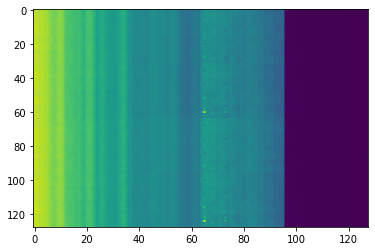

2020-11-22 23:43:00,470 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:0.019585, valid_AUC:0.453468, valid_pAUC:0.494992
100%|██████████| 1803/1803 [00:23<00:00, 76.36it/s]
2020-11-22 23:44:09,378 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:0.013286, valid_AUC:0.466841, valid_pAUC:0.496033
100%|██████████| 1803/1803 [00:23<00:00, 76.35it/s]
2020-11-22 23:45:18,849 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:0.012226, valid_AUC:0.481477, valid_pAUC:0.495470
100%|██████████| 1803/1803 [00:23<00:00, 77.80it/s]
2020-11-22 23:46:27,993 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:0.011860, valid_AUC:0.474695, valid_pAUC:0.496258
100%|██████████| 1803/1803 [00:23<00:00, 76.35it/s]
2020-11-22 23:47:36,875 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:0.011469, valid_AUC:0.477096, valid_pAUC:0.498940
100%|██████████| 1803/1803 [00:23<00:00, 77.80it/s]
2020-11-22 23:48:45,132 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:0.011078, valid_AUC:0.475902

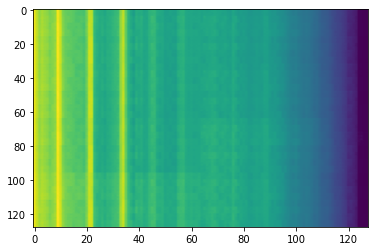

2020-11-22 23:53:18,713 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:0.009865, valid_AUC:0.497411, valid_pAUC:0.501801
100%|██████████| 1803/1803 [00:23<00:00, 76.53it/s]
2020-11-22 23:54:27,568 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:0.009689, valid_AUC:0.485937, valid_pAUC:0.500094
100%|██████████| 1803/1803 [00:23<00:00, 78.06it/s]
2020-11-22 23:55:35,769 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:0.009514, valid_AUC:0.482771, valid_pAUC:0.501154
100%|██████████| 1803/1803 [00:23<00:00, 76.86it/s]
2020-11-22 23:56:43,895 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:0.009419, valid_AUC:0.480877, valid_pAUC:0.500638
100%|██████████| 1803/1803 [00:22<00:00, 79.03it/s]
2020-11-22 23:57:51,989 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:0.009321, valid_AUC:0.483944, valid_pAUC:0.501754
100%|██████████| 1803/1803 [00:23<00:00, 77.63it/s]
2020-11-22 23:59:00,056 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:0.009255, valid_AUC:0.

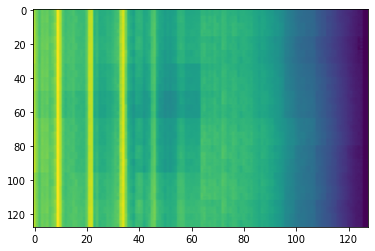

2020-11-23 00:04:41,151 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:0.008961, valid_AUC:0.491711, valid_pAUC:0.502345
100%|██████████| 1803/1803 [00:23<00:00, 77.39it/s]
2020-11-23 00:05:49,956 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:0.008887, valid_AUC:0.490474, valid_pAUC:0.501510
100%|██████████| 1803/1803 [00:24<00:00, 74.48it/s]
2020-11-23 00:06:58,933 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:0.008818, valid_AUC:0.490882, valid_pAUC:0.504089
100%|██████████| 1803/1803 [00:24<00:00, 73.90it/s]
2020-11-23 00:08:08,813 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:0.008778, valid_AUC:0.498411, valid_pAUC:0.504896
100%|██████████| 1803/1803 [00:22<00:00, 79.01it/s]
2020-11-23 00:09:16,642 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:0.008728, valid_AUC:0.491652, valid_pAUC:0.503883
100%|██████████| 1803/1803 [00:22<00:00, 79.78it/s]
2020-11-23 00:10:25,356 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:0.008718, valid_AUC:0.

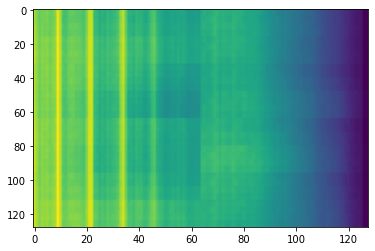

2020-11-23 00:16:06,420 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:0.008622, valid_AUC:0.493160, valid_pAUC:0.504136
100%|██████████| 1803/1803 [00:23<00:00, 76.02it/s]
2020-11-23 00:17:15,771 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:0.008615, valid_AUC:0.490445, valid_pAUC:0.502907
100%|██████████| 1803/1803 [00:23<00:00, 78.21it/s]
2020-11-23 00:18:23,948 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:0.008576, valid_AUC:0.491479, valid_pAUC:0.503658
100%|██████████| 1803/1803 [00:23<00:00, 76.29it/s]
2020-11-23 00:19:32,351 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:0.008532, valid_AUC:0.491146, valid_pAUC:0.503836
100%|██████████| 1803/1803 [00:22<00:00, 79.96it/s]
2020-11-23 00:20:40,228 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:0.008506, valid_AUC:0.493753, valid_pAUC:0.504098
100%|██████████| 1803/1803 [00:23<00:00, 77.08it/s]
2020-11-23 00:21:49,108 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:0.008497, valid_AUC:0.

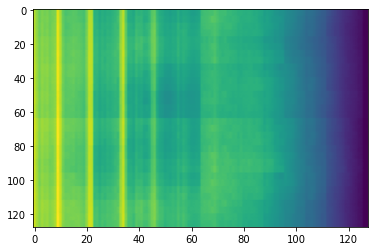

2020-11-23 00:27:26,844 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:0.008397, valid_AUC:0.494171, valid_pAUC:0.504511
100%|██████████| 1803/1803 [00:22<00:00, 80.36it/s]
2020-11-23 00:28:34,218 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:0.008403, valid_AUC:0.505991, valid_pAUC:0.505411
100%|██████████| 1803/1803 [00:22<00:00, 80.83it/s]
2020-11-23 00:29:41,590 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:0.008373, valid_AUC:0.498643, valid_pAUC:0.504108
100%|██████████| 1803/1803 [00:22<00:00, 80.92it/s]
2020-11-23 00:30:48,026 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:0.008370, valid_AUC:0.497810, valid_pAUC:0.504173
100%|██████████| 1803/1803 [00:22<00:00, 80.75it/s]
2020-11-23 00:31:54,500 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:0.008316, valid_AUC:0.492295, valid_pAUC:0.504511
100%|██████████| 1803/1803 [00:22<00:00, 81.23it/s]
2020-11-23 00:33:00,796 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:0.008314, valid_AUC:0.

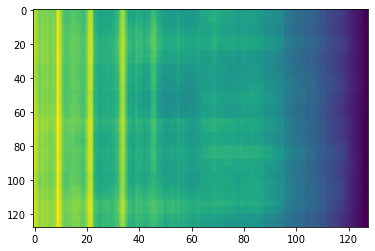

2020-11-23 00:38:29,809 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:0.008175, valid_AUC:0.497717, valid_pAUC:0.504905
100%|██████████| 1803/1803 [00:21<00:00, 83.21it/s]
2020-11-23 00:39:35,245 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:0.008187, valid_AUC:0.494829, valid_pAUC:0.504717
100%|██████████| 1803/1803 [00:21<00:00, 83.09it/s]
2020-11-23 00:40:40,678 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:0.008176, valid_AUC:0.497532, valid_pAUC:0.504736
100%|██████████| 1803/1803 [00:21<00:00, 83.10it/s]
2020-11-23 00:41:46,108 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:0.008153, valid_AUC:0.494615, valid_pAUC:0.504511
100%|██████████| 1803/1803 [00:21<00:00, 83.11it/s]
2020-11-23 00:42:51,575 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:0.008155, valid_AUC:0.495732, valid_pAUC:0.505608
100%|██████████| 1803/1803 [00:21<00:00, 82.92it/s]
2020-11-23 00:43:57,056 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:0.008130, valid_AUC:0.

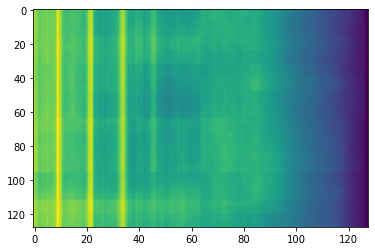

2020-11-23 00:49:24,627 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:0.008043, valid_AUC:0.501244, valid_pAUC:0.504248
100%|██████████| 1803/1803 [00:21<00:00, 83.41it/s]
2020-11-23 00:50:30,054 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:0.008040, valid_AUC:0.494531, valid_pAUC:0.504483
100%|██████████| 1803/1803 [00:21<00:00, 83.19it/s]
2020-11-23 00:51:35,554 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:0.008077, valid_AUC:0.495469, valid_pAUC:0.503264
100%|██████████| 1803/1803 [00:21<00:00, 83.36it/s]
2020-11-23 00:52:40,956 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:0.008049, valid_AUC:0.495306, valid_pAUC:0.505092
100%|██████████| 1803/1803 [00:21<00:00, 83.24it/s]
2020-11-23 00:53:46,394 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:0.008053, valid_AUC:0.498423, valid_pAUC:0.504642
100%|██████████| 1803/1803 [00:21<00:00, 83.19it/s]
2020-11-23 00:54:51,825 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:0.008027, valid_AUC:0.

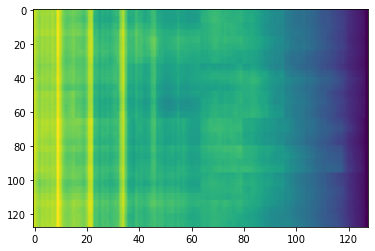

2020-11-23 01:00:19,444 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:0.007880, valid_AUC:0.498222, valid_pAUC:0.504924
100%|██████████| 1803/1803 [00:21<00:00, 83.34it/s]
2020-11-23 01:01:24,825 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:0.007866, valid_AUC:0.500027, valid_pAUC:0.504971
100%|██████████| 1803/1803 [00:21<00:00, 83.19it/s]
2020-11-23 01:02:30,251 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:0.007904, valid_AUC:0.499252, valid_pAUC:0.504849
100%|██████████| 1803/1803 [00:21<00:00, 83.31it/s]
2020-11-23 01:03:35,630 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:0.007861, valid_AUC:0.500433, valid_pAUC:0.504914
100%|██████████| 1803/1803 [00:21<00:00, 83.20it/s]
2020-11-23 01:04:41,062 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:0.007837, valid_AUC:0.497944, valid_pAUC:0.504492
100%|██████████| 1803/1803 [00:21<00:00, 83.32it/s]
2020-11-23 01:05:46,471 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:0.007804, valid_AUC:0.

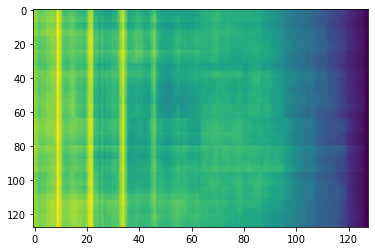

2020-11-23 01:11:14,022 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:0.007702, valid_AUC:0.497812, valid_pAUC:0.504108
100%|██████████| 1803/1803 [00:21<00:00, 83.16it/s]
2020-11-23 01:12:19,447 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:0.007695, valid_AUC:0.499537, valid_pAUC:0.504530
100%|██████████| 1803/1803 [00:21<00:00, 83.13it/s]
2020-11-23 01:13:24,911 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:0.007676, valid_AUC:0.499400, valid_pAUC:0.505027
100%|██████████| 1803/1803 [00:21<00:00, 82.91it/s]
2020-11-23 01:14:30,397 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:0.007662, valid_AUC:0.498487, valid_pAUC:0.504323
100%|██████████| 1803/1803 [00:21<00:00, 83.25it/s]
2020-11-23 01:15:35,764 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:0.007631, valid_AUC:0.497454, valid_pAUC:0.504642
100%|██████████| 1803/1803 [00:21<00:00, 83.14it/s]
2020-11-23 01:16:41,178 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:0.007649, valid_AUC:0.

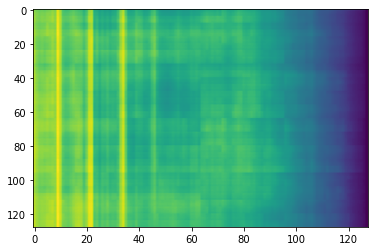

2020-11-23 01:22:08,395 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:0.007570, valid_AUC:0.501319, valid_pAUC:0.504549
100%|██████████| 1803/1803 [00:21<00:00, 82.88it/s]
2020-11-23 01:23:13,917 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:0.007580, valid_AUC:0.500585, valid_pAUC:0.504792
100%|██████████| 1803/1803 [00:21<00:00, 82.96it/s]
2020-11-23 01:24:19,429 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:0.007545, valid_AUC:0.498977, valid_pAUC:0.504699
100%|██████████| 1803/1803 [00:21<00:00, 83.30it/s]
2020-11-23 01:25:24,870 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:0.007558, valid_AUC:0.498705, valid_pAUC:0.503948
100%|██████████| 1803/1803 [00:21<00:00, 83.37it/s]
2020-11-23 01:26:30,283 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:0.007542, valid_AUC:0.501254, valid_pAUC:0.504867
100%|██████████| 1803/1803 [00:21<00:00, 83.07it/s]
2020-11-23 01:27:35,769 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:0.007514, valid_AUC:0.

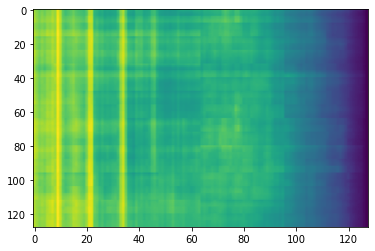

2020-11-23 01:33:03,273 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:0.007457, valid_AUC:0.497650, valid_pAUC:0.503554
2020-11-23 01:33:04,112 - 00_train.py - INFO - 
 success:fan 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/DAGMM_LSTM_CONV_vanilla/models/fan_model.pth


elapsed time: 6673.125098705 [sec]


2020-11-23 01:33:05,307 - 00_train.py - INFO - TARGET MACHINE_TYPE: pump
2020-11-23 01:33:05,308 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-23 01:33:05,310 - 00_train.py - INFO - TRAINING
  0%|          | 0/91 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 832/832 [00:13<00:00, 59.50it/s]


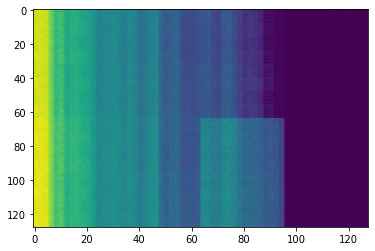

2020-11-23 01:35:15,449 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:0.022844, valid_AUC:0.533102, valid_pAUC:0.504691
100%|██████████| 832/832 [00:10<00:00, 83.14it/s]
2020-11-23 01:36:04,000 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:0.015462, valid_AUC:0.541001, valid_pAUC:0.506153
100%|██████████| 832/832 [00:09<00:00, 83.36it/s]
2020-11-23 01:36:52,576 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:0.014095, valid_AUC:0.557431, valid_pAUC:0.515777
100%|██████████| 832/832 [00:09<00:00, 83.49it/s]
2020-11-23 01:37:41,151 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:0.013542, valid_AUC:0.584641, valid_pAUC:0.522569
100%|██████████| 832/832 [00:09<00:00, 83.21it/s]
2020-11-23 01:38:29,752 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:0.013027, valid_AUC:0.573096, valid_pAUC:0.518458
100%|██████████| 832/832 [00:10<00:00, 83.18it/s]
2020-11-23 01:39:18,412 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:0.012696, valid_AUC:0.583542, valid_pA

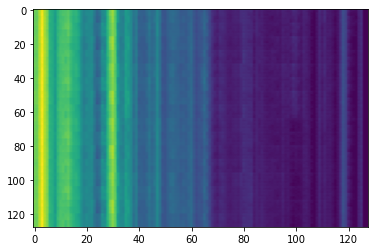

2020-11-23 01:42:33,620 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:0.011509, valid_AUC:0.629410, valid_pAUC:0.533108
100%|██████████| 832/832 [00:10<00:00, 82.73it/s]
2020-11-23 01:43:22,388 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:0.011297, valid_AUC:0.623050, valid_pAUC:0.545535
100%|██████████| 832/832 [00:10<00:00, 82.39it/s]
2020-11-23 01:44:11,256 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:0.011244, valid_AUC:0.629375, valid_pAUC:0.531159
100%|██████████| 832/832 [00:10<00:00, 82.43it/s]
2020-11-23 01:45:00,101 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:0.011126, valid_AUC:0.619311, valid_pAUC:0.534265
100%|██████████| 832/832 [00:10<00:00, 82.49it/s]
2020-11-23 01:45:48,995 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:0.011033, valid_AUC:0.612442, valid_pAUC:0.522265
100%|██████████| 832/832 [00:10<00:00, 82.71it/s]
2020-11-23 01:46:37,725 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:0.010999, valid_AUC:0.621534, va

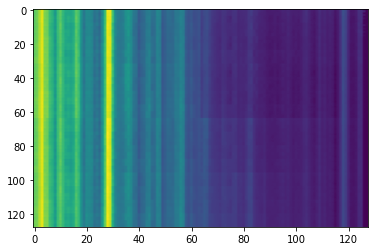

2020-11-23 01:50:42,241 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:0.010631, valid_AUC:0.636528, valid_pAUC:0.534204
100%|██████████| 832/832 [00:10<00:00, 82.61it/s]
2020-11-23 01:51:30,993 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:0.010554, valid_AUC:0.637240, valid_pAUC:0.543525
100%|██████████| 832/832 [00:10<00:00, 82.05it/s]
2020-11-23 01:52:19,877 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:0.010506, valid_AUC:0.637020, valid_pAUC:0.534022
100%|██████████| 832/832 [00:10<00:00, 81.49it/s]
2020-11-23 01:53:08,800 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:0.010510, valid_AUC:0.634288, valid_pAUC:0.535727
100%|██████████| 832/832 [00:10<00:00, 82.30it/s]
2020-11-23 01:53:57,641 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:0.010530, valid_AUC:0.644230, valid_pAUC:0.528600
100%|██████████| 832/832 [00:10<00:00, 82.49it/s]
2020-11-23 01:54:46,415 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:0.010513, valid_AUC:0.637471, va

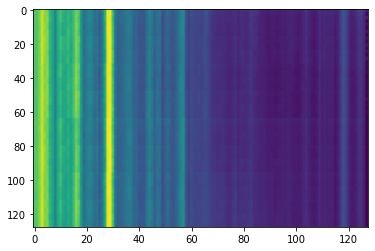

2020-11-23 01:58:55,928 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:0.010174, valid_AUC:0.644404, valid_pAUC:0.534296
100%|██████████| 832/832 [00:10<00:00, 78.11it/s]
2020-11-23 01:59:46,256 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:0.010129, valid_AUC:0.643576, valid_pAUC:0.537311
100%|██████████| 832/832 [00:10<00:00, 80.15it/s]
2020-11-23 02:00:36,078 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:0.010052, valid_AUC:0.644138, valid_pAUC:0.530945
100%|██████████| 832/832 [00:10<00:00, 75.96it/s]
2020-11-23 02:01:27,025 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:0.010008, valid_AUC:0.642477, valid_pAUC:0.534996
100%|██████████| 832/832 [00:10<00:00, 76.83it/s]
2020-11-23 02:02:17,645 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:0.010007, valid_AUC:0.651748, valid_pAUC:0.528417
100%|██████████| 832/832 [00:11<00:00, 74.97it/s]
2020-11-23 02:03:09,022 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:0.010114, valid_AUC:0.639005, va

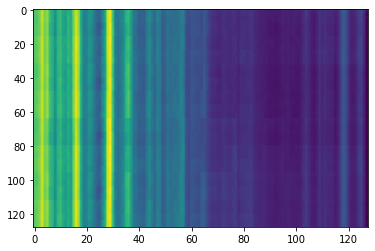

2020-11-23 02:07:21,667 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:0.009722, valid_AUC:0.643137, valid_pAUC:0.530367
100%|██████████| 832/832 [00:10<00:00, 79.99it/s]
2020-11-23 02:08:11,423 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:0.009870, valid_AUC:0.648177, valid_pAUC:0.539200
100%|██████████| 832/832 [00:10<00:00, 79.03it/s]
2020-11-23 02:09:01,059 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:0.009938, valid_AUC:0.662483, valid_pAUC:0.526407
100%|██████████| 832/832 [00:10<00:00, 79.86it/s]
2020-11-23 02:09:50,512 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:0.010015, valid_AUC:0.645527, valid_pAUC:0.535788
100%|██████████| 832/832 [00:10<00:00, 80.53it/s]
2020-11-23 02:10:39,905 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:0.009726, valid_AUC:0.645295, valid_pAUC:0.534539
100%|██████████| 832/832 [00:10<00:00, 79.28it/s]
2020-11-23 02:11:29,496 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:0.009702, valid_AUC:0.648843, va

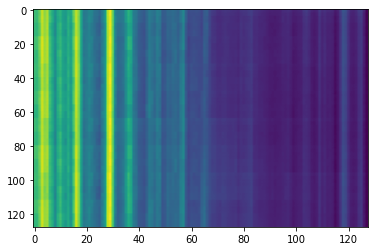

2020-11-23 02:15:35,308 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:0.009611, valid_AUC:0.643542, valid_pAUC:0.537067
100%|██████████| 832/832 [00:10<00:00, 82.29it/s]
2020-11-23 02:16:24,099 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:0.009706, valid_AUC:0.643623, valid_pAUC:0.533504
100%|██████████| 832/832 [00:10<00:00, 82.40it/s]
2020-11-23 02:17:12,990 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:0.009585, valid_AUC:0.653466, valid_pAUC:0.536489
100%|██████████| 832/832 [00:10<00:00, 82.16it/s]
2020-11-23 02:18:01,833 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:0.009558, valid_AUC:0.649103, valid_pAUC:0.541514
100%|██████████| 832/832 [00:10<00:00, 82.33it/s]
2020-11-23 02:18:50,672 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:0.009585, valid_AUC:0.648484, valid_pAUC:0.537494
100%|██████████| 832/832 [00:10<00:00, 82.09it/s]
2020-11-23 02:19:39,625 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:0.009540, valid_AUC:0.645052, va

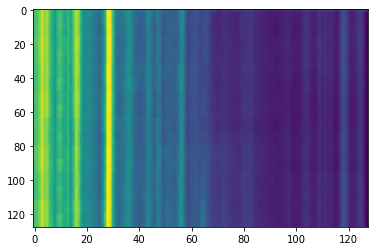

2020-11-23 02:23:43,965 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:0.009387, valid_AUC:0.650440, valid_pAUC:0.535606
100%|██████████| 832/832 [00:10<00:00, 82.41it/s]
2020-11-23 02:24:32,783 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:0.009374, valid_AUC:0.650075, valid_pAUC:0.539778
100%|██████████| 832/832 [00:10<00:00, 82.12it/s]
2020-11-23 02:25:21,653 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:0.009338, valid_AUC:0.652425, valid_pAUC:0.536702
100%|██████████| 832/832 [00:10<00:00, 82.25it/s]
2020-11-23 02:26:10,476 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:0.009316, valid_AUC:0.650932, valid_pAUC:0.537677
100%|██████████| 832/832 [00:10<00:00, 82.55it/s]
2020-11-23 02:26:59,304 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:0.009311, valid_AUC:0.645503, valid_pAUC:0.537829
100%|██████████| 832/832 [00:10<00:00, 82.31it/s]
2020-11-23 02:27:48,123 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:0.009346, valid_AUC:0.652083, va

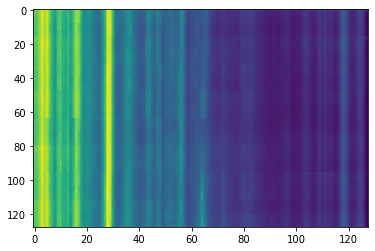

2020-11-23 02:31:52,753 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:0.009226, valid_AUC:0.649144, valid_pAUC:0.537342
100%|██████████| 832/832 [00:10<00:00, 82.38it/s]
2020-11-23 02:32:41,552 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:0.009168, valid_AUC:0.651221, valid_pAUC:0.539382
100%|██████████| 832/832 [00:10<00:00, 82.60it/s]
2020-11-23 02:33:30,345 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:0.009190, valid_AUC:0.651053, valid_pAUC:0.539047
100%|██████████| 832/832 [00:10<00:00, 82.20it/s]
2020-11-23 02:34:19,198 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:0.009192, valid_AUC:0.652326, valid_pAUC:0.537981
100%|██████████| 832/832 [00:10<00:00, 81.60it/s]
2020-11-23 02:35:08,175 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:0.009142, valid_AUC:0.653785, valid_pAUC:0.537433
100%|██████████| 832/832 [00:10<00:00, 82.60it/s]
2020-11-23 02:35:56,991 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:0.009144, valid_AUC:0.656823, va

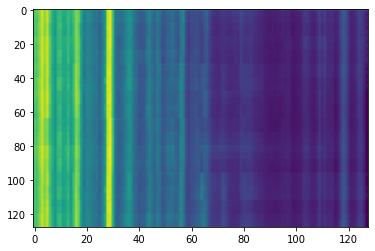

2020-11-23 02:40:01,339 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:0.009079, valid_AUC:0.659051, valid_pAUC:0.540357
100%|██████████| 832/832 [00:10<00:00, 82.60it/s]
2020-11-23 02:40:50,117 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:0.009137, valid_AUC:0.661204, valid_pAUC:0.536123
100%|██████████| 832/832 [00:10<00:00, 82.30it/s]
2020-11-23 02:41:38,953 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:0.009142, valid_AUC:0.650920, valid_pAUC:0.539656
100%|██████████| 832/832 [00:10<00:00, 82.64it/s]
2020-11-23 02:42:27,764 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:0.009032, valid_AUC:0.656447, valid_pAUC:0.541941
100%|██████████| 832/832 [00:10<00:00, 82.52it/s]
2020-11-23 02:43:16,610 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:0.008969, valid_AUC:0.654230, valid_pAUC:0.539474
100%|██████████| 832/832 [00:10<00:00, 81.86it/s]
2020-11-23 02:44:05,509 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:0.008992, valid_AUC:0.658617, va

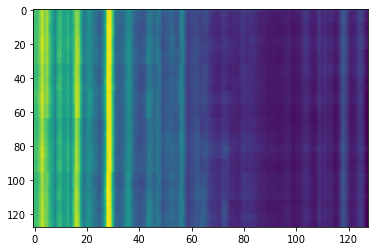

2020-11-23 02:48:09,784 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:0.008950, valid_AUC:0.653206, valid_pAUC:0.538865
100%|██████████| 832/832 [00:10<00:00, 82.61it/s]
2020-11-23 02:48:58,612 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:0.008981, valid_AUC:0.649444, valid_pAUC:0.538469
100%|██████████| 832/832 [00:10<00:00, 82.68it/s]
2020-11-23 02:49:47,399 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:0.008897, valid_AUC:0.657245, valid_pAUC:0.538651
100%|██████████| 832/832 [00:10<00:00, 82.74it/s]
2020-11-23 02:50:36,204 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:0.008874, valid_AUC:0.668634, valid_pAUC:0.534631
100%|██████████| 832/832 [00:10<00:00, 82.25it/s]
2020-11-23 02:51:25,073 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:0.008981, valid_AUC:0.656887, valid_pAUC:0.538255
100%|██████████| 832/832 [00:10<00:00, 82.40it/s]
2020-11-23 02:52:13,878 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:0.008838, valid_AUC:0.652593, va

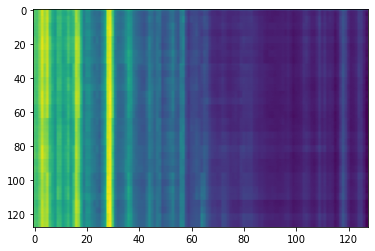

2020-11-23 02:56:18,186 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:0.008732, valid_AUC:0.656360, valid_pAUC:0.538316
2020-11-23 02:56:19,022 - 00_train.py - INFO - 
 success:pump 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/DAGMM_LSTM_CONV_vanilla/models/pump_model.pth


elapsed time: 4993.715353966 [sec]


2020-11-23 02:56:20,211 - 00_train.py - INFO - TARGET MACHINE_TYPE: slider
2020-11-23 02:56:20,212 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-23 02:56:20,213 - 00_train.py - INFO - TRAINING
  0%|          | 0/81 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 1246/1246 [00:21<00:00, 58.56it/s]


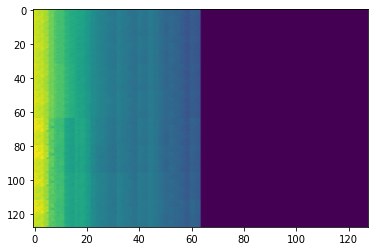

2020-11-23 02:58:23,041 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:0.029528, valid_AUC:0.619731, valid_pAUC:0.508010
100%|██████████| 1246/1246 [00:15<00:00, 81.27it/s]
2020-11-23 02:59:12,960 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:0.020720, valid_AUC:0.655912, valid_pAUC:0.531106
100%|██████████| 1246/1246 [00:15<00:00, 81.88it/s]
2020-11-23 03:00:02,741 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:0.015202, valid_AUC:0.667193, valid_pAUC:0.534543
100%|██████████| 1246/1246 [00:15<00:00, 81.91it/s]
2020-11-23 03:00:52,587 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:0.013708, valid_AUC:0.686348, valid_pAUC:0.524341
100%|██████████| 1246/1246 [00:15<00:00, 81.86it/s]
2020-11-23 03:01:42,398 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:0.012954, valid_AUC:0.711052, valid_pAUC:0.523003
100%|██████████| 1246/1246 [00:15<00:00, 82.09it/s]
2020-11-23 03:02:32,206 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:0.012361, valid_AUC:0.722999

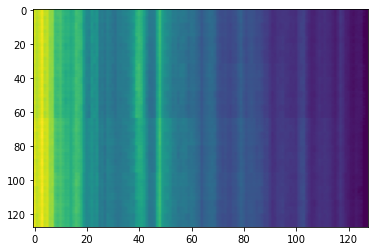

2020-11-23 03:05:51,803 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:0.011421, valid_AUC:0.734530, valid_pAUC:0.566956
100%|██████████| 1246/1246 [00:15<00:00, 82.34it/s]
2020-11-23 03:06:41,522 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:0.011232, valid_AUC:0.739905, valid_pAUC:0.558277
100%|██████████| 1246/1246 [00:15<00:00, 82.30it/s]
2020-11-23 03:07:31,328 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:0.011222, valid_AUC:0.748366, valid_pAUC:0.568978
100%|██████████| 1246/1246 [00:15<00:00, 82.21it/s]
2020-11-23 03:08:21,130 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:0.011098, valid_AUC:0.745491, valid_pAUC:0.560641
100%|██████████| 1246/1246 [00:15<00:00, 81.37it/s]
2020-11-23 03:09:11,110 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:0.011106, valid_AUC:0.740168, valid_pAUC:0.554125
100%|██████████| 1246/1246 [00:15<00:00, 82.32it/s]
2020-11-23 03:10:00,828 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:0.011006, valid_AUC:0.

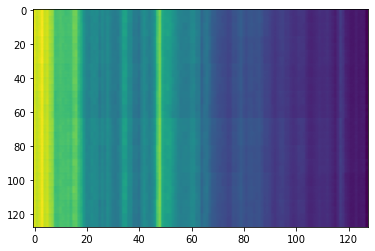

2020-11-23 03:14:09,963 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:0.010754, valid_AUC:0.760417, valid_pAUC:0.581451
100%|██████████| 1246/1246 [00:15<00:00, 82.04it/s]
2020-11-23 03:14:59,829 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:0.010685, valid_AUC:0.769025, valid_pAUC:0.593474
100%|██████████| 1246/1246 [00:15<00:00, 82.18it/s]
2020-11-23 03:15:49,586 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:0.010699, valid_AUC:0.758998, valid_pAUC:0.564172
100%|██████████| 1246/1246 [00:15<00:00, 82.25it/s]
2020-11-23 03:16:39,345 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:0.010619, valid_AUC:0.759693, valid_pAUC:0.577641
100%|██████████| 1246/1246 [00:15<00:00, 82.08it/s]
2020-11-23 03:17:29,121 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:0.010585, valid_AUC:0.762287, valid_pAUC:0.571544
100%|██████████| 1246/1246 [00:15<00:00, 82.13it/s]
2020-11-23 03:18:18,871 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:0.010519, valid_AUC:0.

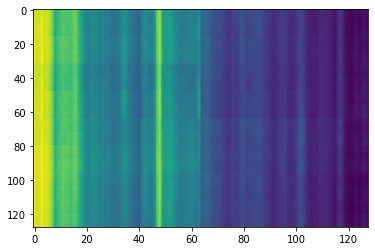

2020-11-23 03:22:27,994 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:0.010255, valid_AUC:0.764888, valid_pAUC:0.572944
100%|██████████| 1246/1246 [00:15<00:00, 81.84it/s]
2020-11-23 03:23:17,945 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:0.010209, valid_AUC:0.762654, valid_pAUC:0.573193
100%|██████████| 1246/1246 [00:15<00:00, 81.96it/s]
2020-11-23 03:24:07,801 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:0.010158, valid_AUC:0.766625, valid_pAUC:0.571529
100%|██████████| 1246/1246 [00:15<00:00, 82.41it/s]
2020-11-23 03:24:57,552 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:0.010072, valid_AUC:0.768203, valid_pAUC:0.570362
100%|██████████| 1246/1246 [00:15<00:00, 82.02it/s]
2020-11-23 03:25:47,479 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:0.010084, valid_AUC:0.760352, valid_pAUC:0.564530
100%|██████████| 1246/1246 [00:15<00:00, 81.82it/s]
2020-11-23 03:26:37,327 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:0.009930, valid_AUC:0.

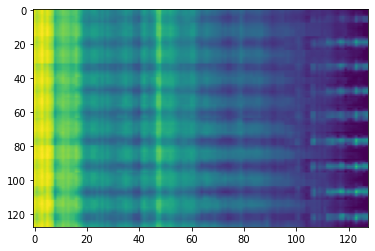

2020-11-23 03:30:46,538 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:0.009490, valid_AUC:0.796616, valid_pAUC:0.579958
100%|██████████| 1246/1246 [00:15<00:00, 82.04it/s]
2020-11-23 03:31:36,413 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:0.009345, valid_AUC:0.794719, valid_pAUC:0.580098
100%|██████████| 1246/1246 [00:15<00:00, 82.27it/s]
2020-11-23 03:32:26,174 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:0.009366, valid_AUC:0.794158, valid_pAUC:0.572228
100%|██████████| 1246/1246 [00:15<00:00, 81.57it/s]
2020-11-23 03:33:16,057 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:0.009339, valid_AUC:0.793319, valid_pAUC:0.574624
100%|██████████| 1246/1246 [00:15<00:00, 81.81it/s]
2020-11-23 03:34:05,868 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:0.009200, valid_AUC:0.797110, valid_pAUC:0.578714
100%|██████████| 1246/1246 [00:15<00:00, 82.48it/s]
2020-11-23 03:34:55,614 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:0.009123, valid_AUC:0.

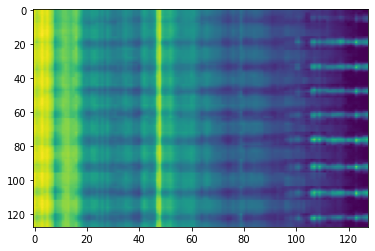

2020-11-23 03:39:04,825 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:0.008913, valid_AUC:0.797822, valid_pAUC:0.578885
100%|██████████| 1246/1246 [00:15<00:00, 82.43it/s]
2020-11-23 03:39:54,552 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:0.008926, valid_AUC:0.801936, valid_pAUC:0.584609
100%|██████████| 1246/1246 [00:15<00:00, 82.50it/s]
2020-11-23 03:40:44,286 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:0.008895, valid_AUC:0.800464, valid_pAUC:0.575075
100%|██████████| 1246/1246 [00:15<00:00, 82.26it/s]
2020-11-23 03:41:34,181 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:0.008869, valid_AUC:0.803862, valid_pAUC:0.584858
100%|██████████| 1246/1246 [00:15<00:00, 82.46it/s]
2020-11-23 03:42:23,929 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:0.008819, valid_AUC:0.801194, valid_pAUC:0.578870
100%|██████████| 1246/1246 [00:15<00:00, 81.51it/s]
2020-11-23 03:43:13,869 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:0.008750, valid_AUC:0.

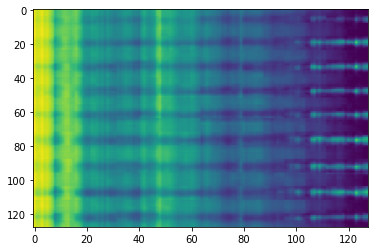

2020-11-23 03:47:22,898 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:0.008609, valid_AUC:0.807364, valid_pAUC:0.587984
100%|██████████| 1246/1246 [00:15<00:00, 82.34it/s]
2020-11-23 03:48:12,622 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:0.008558, valid_AUC:0.807234, valid_pAUC:0.584889
100%|██████████| 1246/1246 [00:15<00:00, 81.65it/s]
2020-11-23 03:49:02,456 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:0.008551, valid_AUC:0.809486, valid_pAUC:0.589772
100%|██████████| 1246/1246 [00:15<00:00, 82.34it/s]
2020-11-23 03:49:52,196 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:0.008517, valid_AUC:0.806773, valid_pAUC:0.585215
100%|██████████| 1246/1246 [00:15<00:00, 82.45it/s]
2020-11-23 03:50:41,902 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:0.008471, valid_AUC:0.811673, valid_pAUC:0.586304
100%|██████████| 1246/1246 [00:15<00:00, 82.11it/s]
2020-11-23 03:51:31,667 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:0.008451, valid_AUC:0.

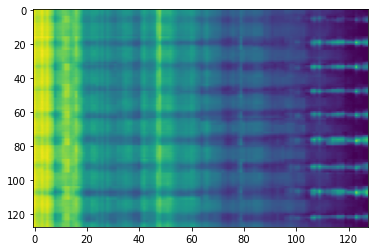

2020-11-23 03:55:40,573 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:0.008333, valid_AUC:0.808723, valid_pAUC:0.584733
100%|██████████| 1246/1246 [00:15<00:00, 82.48it/s]
2020-11-23 03:56:30,283 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:0.008280, valid_AUC:0.810074, valid_pAUC:0.582105
100%|██████████| 1246/1246 [00:15<00:00, 82.35it/s]
2020-11-23 03:57:20,009 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:0.008271, valid_AUC:0.808106, valid_pAUC:0.578419
100%|██████████| 1246/1246 [00:15<00:00, 82.46it/s]
2020-11-23 03:58:09,757 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:0.008223, valid_AUC:0.807725, valid_pAUC:0.581902
100%|██████████| 1246/1246 [00:15<00:00, 82.37it/s]
2020-11-23 03:58:59,488 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:0.008232, valid_AUC:0.810408, valid_pAUC:0.584033
100%|██████████| 1246/1246 [00:15<00:00, 82.54it/s]
2020-11-23 03:59:49,195 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:0.008202, valid_AUC:0.

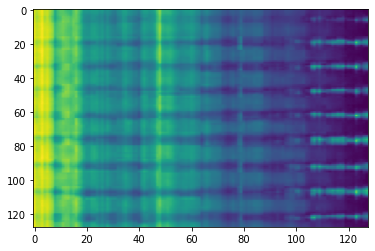

2020-11-23 04:03:58,272 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:0.008035, valid_AUC:0.807810, valid_pAUC:0.574670
100%|██████████| 1246/1246 [00:15<00:00, 82.47it/s]
2020-11-23 04:04:48,009 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:0.008024, valid_AUC:0.806179, valid_pAUC:0.580300
100%|██████████| 1246/1246 [00:15<00:00, 82.37it/s]
2020-11-23 04:05:37,762 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:0.007987, valid_AUC:0.807982, valid_pAUC:0.583318
100%|██████████| 1246/1246 [00:15<00:00, 82.31it/s]
2020-11-23 04:06:27,484 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:0.007975, valid_AUC:0.808020, valid_pAUC:0.585417
100%|██████████| 1246/1246 [00:15<00:00, 82.47it/s]
2020-11-23 04:07:17,204 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:0.007959, valid_AUC:0.807937, valid_pAUC:0.575697
100%|██████████| 1246/1246 [00:15<00:00, 82.24it/s]
2020-11-23 04:08:06,949 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:0.007922, valid_AUC:0.

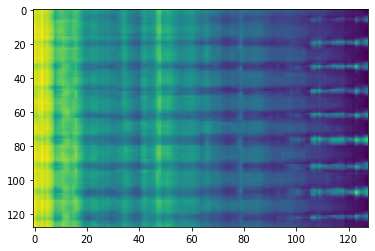

2020-11-23 04:12:15,981 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:0.007816, valid_AUC:0.807928, valid_pAUC:0.577874
100%|██████████| 1246/1246 [00:15<00:00, 81.55it/s]
2020-11-23 04:13:05,944 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:0.007795, valid_AUC:0.807494, valid_pAUC:0.578356
100%|██████████| 1246/1246 [00:15<00:00, 82.21it/s]
2020-11-23 04:13:55,744 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:0.007784, valid_AUC:0.806300, valid_pAUC:0.578030
100%|██████████| 1246/1246 [00:15<00:00, 82.32it/s]
2020-11-23 04:14:45,505 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:0.007722, valid_AUC:0.806871, valid_pAUC:0.574904
100%|██████████| 1246/1246 [00:15<00:00, 82.14it/s]
2020-11-23 04:15:35,352 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:0.007689, valid_AUC:0.803579, valid_pAUC:0.575930
100%|██████████| 1246/1246 [00:15<00:00, 82.47it/s]
2020-11-23 04:16:25,008 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:0.007669, valid_AUC:0.

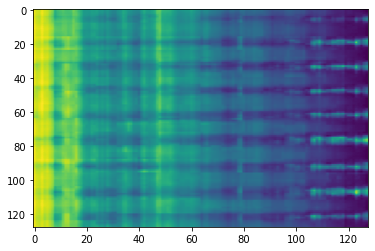

2020-11-23 04:20:33,964 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:0.007574, valid_AUC:0.805313, valid_pAUC:0.573208
2020-11-23 04:20:34,788 - 00_train.py - INFO - 
 success:slider 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/DAGMM_LSTM_CONV_vanilla/models/slider_model.pth


elapsed time: 5054.577727795 [sec]


2020-11-23 04:20:36,054 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyCar
2020-11-23 04:20:36,055 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-23 04:20:36,057 - 00_train.py - INFO - TRAINING
  0%|          | 0/110 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 2407/2407 [00:42<00:00, 57.14it/s]


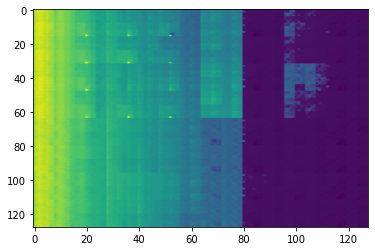

2020-11-23 04:23:45,696 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:0.015230, valid_AUC:0.660331, valid_pAUC:0.562838
100%|██████████| 2407/2407 [00:29<00:00, 82.02it/s]
2020-11-23 04:25:02,167 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:0.005988, valid_AUC:0.695216, valid_pAUC:0.551680
100%|██████████| 2407/2407 [00:29<00:00, 82.49it/s]
2020-11-23 04:26:18,539 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:0.004776, valid_AUC:0.671231, valid_pAUC:0.539994
100%|██████████| 2407/2407 [00:29<00:00, 82.35it/s]
2020-11-23 04:27:35,071 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:0.004505, valid_AUC:0.683415, valid_pAUC:0.547450
100%|██████████| 2407/2407 [00:29<00:00, 82.28it/s]
2020-11-23 04:28:51,500 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:0.004313, valid_AUC:0.694225, valid_pAUC:0.559650
100%|██████████| 2407/2407 [00:29<00:00, 82.42it/s]
2020-11-23 04:30:08,032 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:0.004205, valid_AUC:0.695651

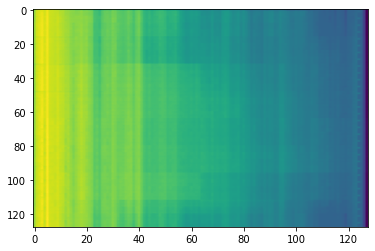

2020-11-23 04:35:14,341 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:0.003979, valid_AUC:0.725586, valid_pAUC:0.576646
100%|██████████| 2407/2407 [00:29<00:00, 82.47it/s]
2020-11-23 04:36:30,794 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:0.003928, valid_AUC:0.717453, valid_pAUC:0.572829
100%|██████████| 2407/2407 [00:29<00:00, 82.32it/s]
2020-11-23 04:37:47,407 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:0.003881, valid_AUC:0.728796, valid_pAUC:0.574942
100%|██████████| 2407/2407 [00:29<00:00, 81.87it/s]
2020-11-23 04:39:04,063 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:0.003866, valid_AUC:0.720588, valid_pAUC:0.573127
100%|██████████| 2407/2407 [00:29<00:00, 82.33it/s]
2020-11-23 04:40:20,516 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:0.003858, valid_AUC:0.728021, valid_pAUC:0.575651
100%|██████████| 2407/2407 [00:29<00:00, 82.41it/s]
2020-11-23 04:41:37,020 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:0.003817, valid_AUC:0.

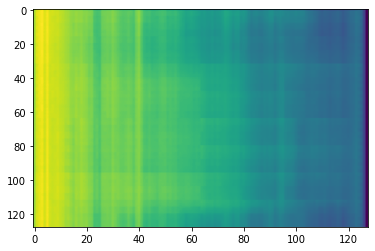

2020-11-23 04:47:59,779 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:0.003742, valid_AUC:0.741094, valid_pAUC:0.581027
100%|██████████| 2407/2407 [00:29<00:00, 81.64it/s]
2020-11-23 04:49:16,429 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:0.003722, valid_AUC:0.742904, valid_pAUC:0.583832
100%|██████████| 2407/2407 [00:29<00:00, 82.43it/s]
2020-11-23 04:50:32,928 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:0.003693, valid_AUC:0.751258, valid_pAUC:0.579377
100%|██████████| 2407/2407 [00:29<00:00, 82.30it/s]
2020-11-23 04:51:49,627 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:0.003668, valid_AUC:0.748217, valid_pAUC:0.579601
100%|██████████| 2407/2407 [00:29<00:00, 81.90it/s]
2020-11-23 04:53:06,230 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:0.003648, valid_AUC:0.715482, valid_pAUC:0.574971
100%|██████████| 2407/2407 [00:29<00:00, 82.18it/s]
2020-11-23 04:54:22,806 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:0.003633, valid_AUC:0.

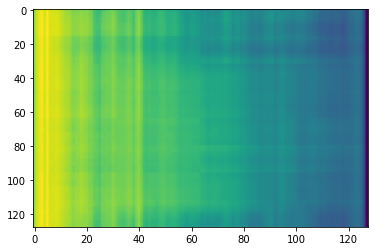

2020-11-23 05:00:45,246 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:0.003559, valid_AUC:0.742179, valid_pAUC:0.575199
100%|██████████| 2407/2407 [00:29<00:00, 82.38it/s]
2020-11-23 05:02:01,695 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:0.003546, valid_AUC:0.762297, valid_pAUC:0.589793
100%|██████████| 2407/2407 [00:29<00:00, 81.86it/s]
2020-11-23 05:03:18,351 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:0.003537, valid_AUC:0.747916, valid_pAUC:0.575306
100%|██████████| 2407/2407 [00:29<00:00, 82.45it/s]
2020-11-23 05:04:34,842 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:0.003530, valid_AUC:0.766847, valid_pAUC:0.590386
100%|██████████| 2407/2407 [00:29<00:00, 82.54it/s]
2020-11-23 05:05:51,312 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:0.003494, valid_AUC:0.752349, valid_pAUC:0.583662
100%|██████████| 2407/2407 [00:29<00:00, 81.97it/s]
2020-11-23 05:07:07,938 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:0.003473, valid_AUC:0.

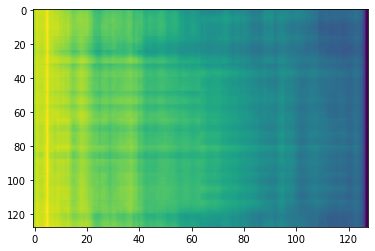

2020-11-23 05:13:30,711 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:0.003398, valid_AUC:0.744990, valid_pAUC:0.581400
100%|██████████| 2407/2407 [00:29<00:00, 82.46it/s]
2020-11-23 05:14:47,128 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:0.003391, valid_AUC:0.758449, valid_pAUC:0.601780
100%|██████████| 2407/2407 [00:29<00:00, 82.41it/s]
2020-11-23 05:16:03,594 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:0.003393, valid_AUC:0.748894, valid_pAUC:0.582520
100%|██████████| 2407/2407 [00:29<00:00, 81.88it/s]
2020-11-23 05:17:20,222 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:0.003379, valid_AUC:0.748860, valid_pAUC:0.584114
100%|██████████| 2407/2407 [00:29<00:00, 82.40it/s]
2020-11-23 05:18:36,753 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:0.003371, valid_AUC:0.749079, valid_pAUC:0.580205
100%|██████████| 2407/2407 [00:29<00:00, 82.40it/s]
2020-11-23 05:19:53,232 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:0.003347, valid_AUC:0.

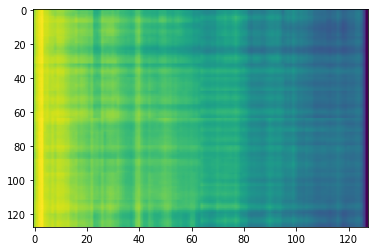

2020-11-23 05:26:16,088 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:0.003267, valid_AUC:0.743263, valid_pAUC:0.581370
100%|██████████| 2407/2407 [00:29<00:00, 82.37it/s]
2020-11-23 05:27:32,574 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:0.003239, valid_AUC:0.775996, valid_pAUC:0.602075
100%|██████████| 2407/2407 [00:29<00:00, 82.38it/s]
2020-11-23 05:28:49,006 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:0.003214, valid_AUC:0.746781, valid_pAUC:0.583465
100%|██████████| 2407/2407 [00:29<00:00, 82.37it/s]
2020-11-23 05:30:05,700 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:0.003179, valid_AUC:0.750685, valid_pAUC:0.581408
100%|██████████| 2407/2407 [00:29<00:00, 81.90it/s]
2020-11-23 05:31:22,371 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:0.003153, valid_AUC:0.784743, valid_pAUC:0.600668
100%|██████████| 2407/2407 [00:29<00:00, 82.26it/s]
2020-11-23 05:32:38,907 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:0.003133, valid_AUC:0.

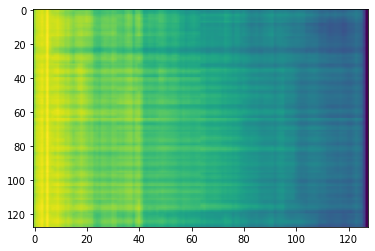

2020-11-23 05:39:01,860 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:0.003041, valid_AUC:0.773723, valid_pAUC:0.599219
100%|██████████| 2407/2407 [00:29<00:00, 82.39it/s]
2020-11-23 05:40:18,421 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:0.003023, valid_AUC:0.764750, valid_pAUC:0.594511
100%|██████████| 2407/2407 [00:29<00:00, 82.34it/s]
2020-11-23 05:41:34,940 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:0.003002, valid_AUC:0.751055, valid_pAUC:0.583532
100%|██████████| 2407/2407 [00:29<00:00, 82.48it/s]
2020-11-23 05:42:51,416 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:0.002966, valid_AUC:0.780565, valid_pAUC:0.588617
100%|██████████| 2407/2407 [00:29<00:00, 82.11it/s]
2020-11-23 05:44:08,089 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:0.002929, valid_AUC:0.751338, valid_pAUC:0.580317
100%|██████████| 2407/2407 [00:29<00:00, 81.98it/s]
2020-11-23 05:45:24,699 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:0.002906, valid_AUC:0.

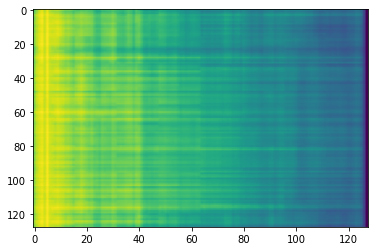

2020-11-23 05:51:47,336 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:0.002774, valid_AUC:0.763059, valid_pAUC:0.580112
100%|██████████| 2407/2407 [00:29<00:00, 81.86it/s]
2020-11-23 05:53:04,036 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:0.002757, valid_AUC:0.779444, valid_pAUC:0.600679
100%|██████████| 2407/2407 [00:29<00:00, 82.18it/s]
2020-11-23 05:54:20,558 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:0.002745, valid_AUC:0.762818, valid_pAUC:0.583270
100%|██████████| 2407/2407 [00:29<00:00, 82.41it/s]
2020-11-23 05:55:37,080 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:0.002726, valid_AUC:0.759808, valid_pAUC:0.583614
100%|██████████| 2407/2407 [00:29<00:00, 82.40it/s]
2020-11-23 05:56:53,636 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:0.002711, valid_AUC:0.761196, valid_pAUC:0.576819
100%|██████████| 2407/2407 [00:29<00:00, 82.44it/s]
2020-11-23 05:58:10,163 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:0.002702, valid_AUC:0.

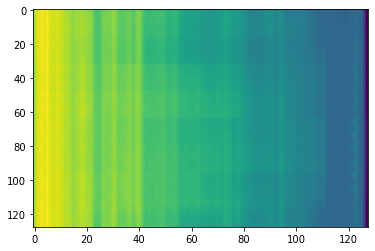

2020-11-23 06:04:33,293 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:0.004116, valid_AUC:0.712758, valid_pAUC:0.570988
100%|██████████| 2407/2407 [00:29<00:00, 82.12it/s]
2020-11-23 06:05:49,864 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:0.004035, valid_AUC:0.726055, valid_pAUC:0.616482
100%|██████████| 2407/2407 [00:29<00:00, 81.88it/s]
2020-11-23 06:07:06,560 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:0.003965, valid_AUC:0.733918, valid_pAUC:0.588631
100%|██████████| 2407/2407 [00:29<00:00, 82.34it/s]
2020-11-23 06:08:23,090 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:0.003900, valid_AUC:0.728039, valid_pAUC:0.580706
100%|██████████| 2407/2407 [00:29<00:00, 82.35it/s]
2020-11-23 06:09:39,673 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:0.003870, valid_AUC:0.728594, valid_pAUC:0.588157
100%|██████████| 2407/2407 [00:29<00:00, 82.39it/s]
2020-11-23 06:10:56,097 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:0.003831, valid_AUC:0.

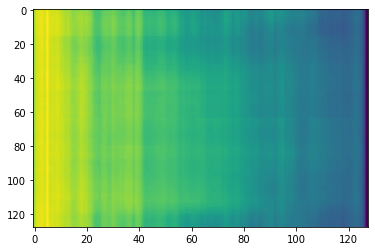

2020-11-23 06:17:18,944 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:0.003691, valid_AUC:0.730940, valid_pAUC:0.583700
100%|██████████| 2407/2407 [00:29<00:00, 82.56it/s]
2020-11-23 06:18:35,364 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:0.003683, valid_AUC:0.740360, valid_pAUC:0.579866
100%|██████████| 2407/2407 [00:29<00:00, 82.22it/s]
2020-11-23 06:19:51,934 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:0.003674, valid_AUC:0.732168, valid_pAUC:0.579511
100%|██████████| 2407/2407 [00:29<00:00, 82.00it/s]
2020-11-23 06:21:08,509 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:0.003653, valid_AUC:0.731742, valid_pAUC:0.565444
100%|██████████| 2407/2407 [00:29<00:00, 82.31it/s]
2020-11-23 06:22:25,071 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:0.003617, valid_AUC:0.721280, valid_pAUC:0.528881
100%|██████████| 2407/2407 [00:29<00:00, 82.48it/s]
2020-11-23 06:23:41,569 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:0.003570, valid_AUC:0.

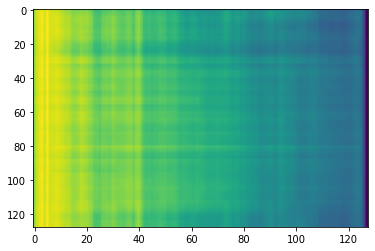

2020-11-23 06:30:04,203 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:0.003476, valid_AUC:0.751216, valid_pAUC:0.584107
2020-11-23 06:30:05,003 - 00_train.py - INFO - 
 success:ToyCar 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/DAGMM_LSTM_CONV_vanilla/models/ToyCar_model.pth


elapsed time: 7768.950101614 [sec]


2020-11-23 06:30:06,308 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyConveyor
2020-11-23 06:30:06,308 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-23 06:30:06,310 - 00_train.py - INFO - TRAINING
  0%|          | 0/94 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 3452/3452 [00:59<00:00, 58.33it/s]


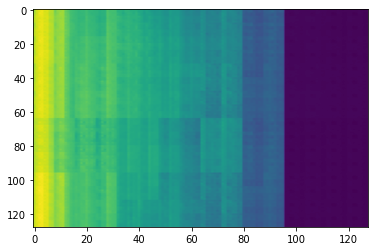

2020-11-23 06:33:09,303 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:0.013435, valid_AUC:0.546346, valid_pAUC:0.504322
100%|██████████| 3452/3452 [00:42<00:00, 81.78it/s]
2020-11-23 06:34:31,491 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:0.005812, valid_AUC:0.550063, valid_pAUC:0.504889
100%|██████████| 3452/3452 [00:42<00:00, 82.08it/s]
2020-11-23 06:35:53,635 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:0.004954, valid_AUC:0.551867, valid_pAUC:0.504874
100%|██████████| 3452/3452 [00:42<00:00, 81.68it/s]
2020-11-23 06:37:16,048 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:0.004683, valid_AUC:0.546446, valid_pAUC:0.508259
100%|██████████| 3452/3452 [00:42<00:00, 81.90it/s]
2020-11-23 06:38:38,303 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:0.004571, valid_AUC:0.559664, valid_pAUC:0.503930
100%|██████████| 3452/3452 [00:42<00:00, 81.85it/s]
2020-11-23 06:40:00,603 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:0.004506, valid_AUC:0.550244

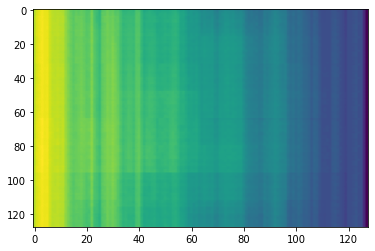

2020-11-23 06:45:30,052 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:0.004164, valid_AUC:0.564044, valid_pAUC:0.503627
100%|██████████| 3452/3452 [00:42<00:00, 82.12it/s]
2020-11-23 06:46:52,219 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:0.004074, valid_AUC:0.567758, valid_pAUC:0.503341
100%|██████████| 3452/3452 [00:42<00:00, 82.14it/s]
2020-11-23 06:48:14,360 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:0.004025, valid_AUC:0.563765, valid_pAUC:0.503264
100%|██████████| 3452/3452 [00:42<00:00, 81.62it/s]
2020-11-23 06:49:36,803 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:0.003948, valid_AUC:0.573277, valid_pAUC:0.502675
100%|██████████| 3452/3452 [00:42<00:00, 82.18it/s]
2020-11-23 06:50:58,892 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:0.003899, valid_AUC:0.566826, valid_pAUC:0.501571
100%|██████████| 3452/3452 [00:42<00:00, 82.07it/s]
2020-11-23 06:52:21,036 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:0.003889, valid_AUC:0.

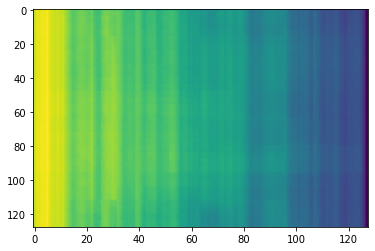

2020-11-23 06:59:12,484 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:0.003725, valid_AUC:0.582060, valid_pAUC:0.505652
100%|██████████| 3452/3452 [00:42<00:00, 82.15it/s]
2020-11-23 07:00:34,722 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:0.003686, valid_AUC:0.584905, valid_pAUC:0.507085
100%|██████████| 3452/3452 [00:42<00:00, 82.03it/s]
2020-11-23 07:01:56,920 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:0.003653, valid_AUC:0.587777, valid_pAUC:0.506398
100%|██████████| 3452/3452 [00:42<00:00, 81.67it/s]
2020-11-23 07:03:19,300 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:0.003639, valid_AUC:0.579877, valid_pAUC:0.505351
100%|██████████| 3452/3452 [00:42<00:00, 81.93it/s]
2020-11-23 07:04:41,546 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:0.003622, valid_AUC:0.590274, valid_pAUC:0.505285
100%|██████████| 3452/3452 [00:41<00:00, 82.20it/s]
2020-11-23 07:06:03,674 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:0.003605, valid_AUC:0.

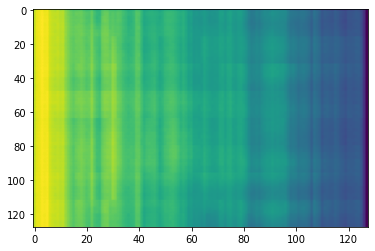

2020-11-23 07:12:55,112 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:0.003498, valid_AUC:0.596193, valid_pAUC:0.509506
100%|██████████| 3452/3452 [00:42<00:00, 82.09it/s]
2020-11-23 07:14:17,336 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:0.003471, valid_AUC:0.589560, valid_pAUC:0.507483
100%|██████████| 3452/3452 [00:42<00:00, 81.74it/s]
2020-11-23 07:15:39,666 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:0.003458, valid_AUC:0.594554, valid_pAUC:0.510719
100%|██████████| 3452/3452 [00:42<00:00, 81.83it/s]
2020-11-23 07:17:01,951 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:0.003490, valid_AUC:0.596359, valid_pAUC:0.511389
100%|██████████| 3452/3452 [00:42<00:00, 82.15it/s]
2020-11-23 07:18:24,132 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:0.003433, valid_AUC:0.600393, valid_pAUC:0.509860
100%|██████████| 3452/3452 [00:42<00:00, 82.00it/s]
2020-11-23 07:19:46,341 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:0.003403, valid_AUC:0.

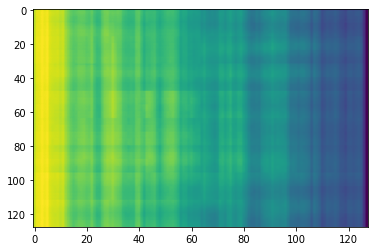

2020-11-23 07:26:37,550 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:0.003320, valid_AUC:0.589222, valid_pAUC:0.507734
100%|██████████| 3452/3452 [00:42<00:00, 82.09it/s]
2020-11-23 07:27:59,879 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:0.003305, valid_AUC:0.586329, valid_pAUC:0.510111
100%|██████████| 3452/3452 [00:42<00:00, 81.55it/s]
2020-11-23 07:29:22,317 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:0.003285, valid_AUC:0.586467, valid_pAUC:0.508659
100%|██████████| 3452/3452 [00:42<00:00, 82.15it/s]
2020-11-23 07:30:44,472 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:0.003281, valid_AUC:0.596046, valid_pAUC:0.509522
100%|██████████| 3452/3452 [00:42<00:00, 81.92it/s]
2020-11-23 07:32:06,837 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:0.003259, valid_AUC:0.594664, valid_pAUC:0.506803
100%|██████████| 3452/3452 [00:42<00:00, 81.90it/s]
2020-11-23 07:33:29,145 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:0.003230, valid_AUC:0.

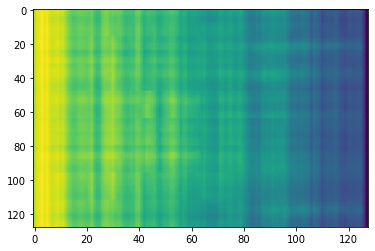

2020-11-23 07:40:20,514 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:0.003157, valid_AUC:0.593434, valid_pAUC:0.507873
100%|██████████| 3452/3452 [00:42<00:00, 81.78it/s]
2020-11-23 07:41:42,821 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:0.003139, valid_AUC:0.585755, valid_pAUC:0.506968
100%|██████████| 3452/3452 [00:42<00:00, 81.89it/s]
2020-11-23 07:43:05,145 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:0.003127, valid_AUC:0.592520, valid_pAUC:0.508526
100%|██████████| 3452/3452 [00:42<00:00, 81.85it/s]
2020-11-23 07:44:27,453 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:0.003118, valid_AUC:0.604354, valid_pAUC:0.509431
100%|██████████| 3452/3452 [00:42<00:00, 82.18it/s]
2020-11-23 07:45:49,590 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:0.003108, valid_AUC:0.595203, valid_pAUC:0.506672
100%|██████████| 3452/3452 [00:42<00:00, 81.81it/s]
2020-11-23 07:47:11,914 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:0.003050, valid_AUC:0.

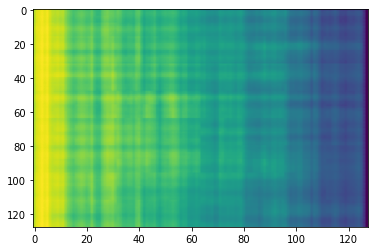

2020-11-23 07:54:03,038 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:0.002969, valid_AUC:0.600558, valid_pAUC:0.508932
100%|██████████| 3452/3452 [00:42<00:00, 81.77it/s]
2020-11-23 07:55:25,367 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:0.002957, valid_AUC:0.600582, valid_pAUC:0.508020
100%|██████████| 3452/3452 [00:42<00:00, 82.13it/s]
2020-11-23 07:56:47,498 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:0.002936, valid_AUC:0.610551, valid_pAUC:0.510222
100%|██████████| 3452/3452 [00:42<00:00, 82.07it/s]
2020-11-23 07:58:09,803 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:0.002964, valid_AUC:0.590927, valid_pAUC:0.508679
100%|██████████| 3452/3452 [00:42<00:00, 81.51it/s]
2020-11-23 07:59:32,321 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:0.003018, valid_AUC:0.605466, valid_pAUC:0.507828
100%|██████████| 3452/3452 [00:41<00:00, 82.23it/s]
2020-11-23 08:00:54,416 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:0.002906, valid_AUC:0.

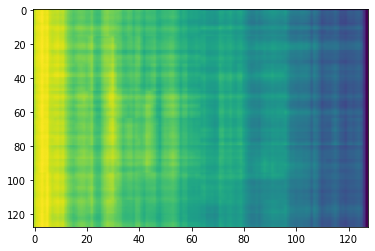

2020-11-23 08:07:45,910 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:0.002790, valid_AUC:0.599014, valid_pAUC:0.509143
100%|██████████| 3452/3452 [00:42<00:00, 81.68it/s]
2020-11-23 08:09:08,299 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:0.002791, valid_AUC:0.599708, valid_pAUC:0.507573
100%|██████████| 3452/3452 [00:41<00:00, 82.20it/s]
2020-11-23 08:10:30,520 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:0.002776, valid_AUC:0.612459, valid_pAUC:0.514076
100%|██████████| 3452/3452 [00:42<00:00, 82.15it/s]
2020-11-23 08:11:52,743 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:0.002771, valid_AUC:0.607823, valid_pAUC:0.507845
100%|██████████| 3452/3452 [00:42<00:00, 82.04it/s]
2020-11-23 08:13:15,009 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:0.002771, valid_AUC:0.599822, valid_pAUC:0.509401
100%|██████████| 3452/3452 [00:42<00:00, 82.05it/s]
2020-11-23 08:14:37,320 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:0.002737, valid_AUC:0.

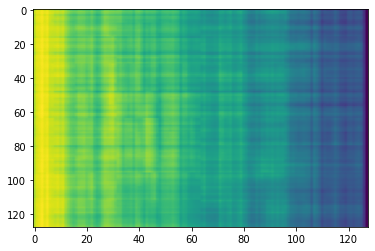

2020-11-23 08:21:28,844 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:0.002630, valid_AUC:0.603464, valid_pAUC:0.508068
100%|██████████| 3452/3452 [00:41<00:00, 82.33it/s]
2020-11-23 08:22:50,967 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:0.002615, valid_AUC:0.574054, valid_pAUC:0.510519
100%|██████████| 3452/3452 [00:42<00:00, 81.78it/s]
2020-11-23 08:24:13,502 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:0.002582, valid_AUC:0.610437, valid_pAUC:0.508106
100%|██████████| 3452/3452 [00:42<00:00, 81.96it/s]
2020-11-23 08:25:35,807 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:0.002546, valid_AUC:0.614228, valid_pAUC:0.509754
100%|██████████| 3452/3452 [00:41<00:00, 82.38it/s]
2020-11-23 08:26:57,916 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:0.002541, valid_AUC:0.607434, valid_pAUC:0.507695
100%|██████████| 3452/3452 [00:42<00:00, 82.07it/s]
2020-11-23 08:28:20,250 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:0.002520, valid_AUC:0.

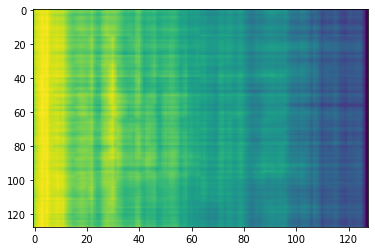

2020-11-23 08:35:12,131 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:0.002460, valid_AUC:0.595477, valid_pAUC:0.509857
100%|██████████| 3452/3452 [00:41<00:00, 82.20it/s]
2020-11-23 08:36:34,337 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:0.002446, valid_AUC:0.604989, valid_pAUC:0.507550
100%|██████████| 3452/3452 [00:42<00:00, 82.19it/s]
2020-11-23 08:37:56,534 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:0.002435, valid_AUC:0.597058, valid_pAUC:0.507894
100%|██████████| 3452/3452 [00:42<00:00, 81.78it/s]
2020-11-23 08:39:18,940 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:0.002427, valid_AUC:0.618669, valid_pAUC:0.512003
100%|██████████| 3452/3452 [00:42<00:00, 82.15it/s]
2020-11-23 08:40:41,128 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:0.002414, valid_AUC:0.611427, valid_pAUC:0.511251
100%|██████████| 3452/3452 [00:41<00:00, 82.37it/s]
2020-11-23 08:42:03,267 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:0.002398, valid_AUC:0.

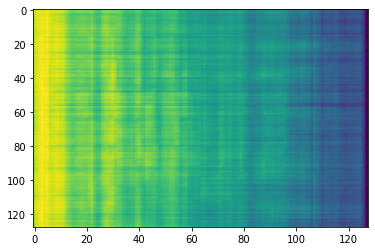

2020-11-23 08:48:54,460 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:0.002276, valid_AUC:0.602770, valid_pAUC:0.509053
2020-11-23 08:48:55,305 - 00_train.py - INFO - 
 success:ToyConveyor 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/DAGMM_LSTM_CONV_vanilla/models/ToyConveyor_model.pth


elapsed time: 8328.998331308 [sec]


2020-11-23 08:48:56,565 - 00_train.py - INFO - TARGET MACHINE_TYPE: valve
2020-11-23 08:48:56,566 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-23 08:48:56,567 - 00_train.py - INFO - TRAINING
  0%|          | 0/91 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 855/855 [00:14<00:00, 57.51it/s]


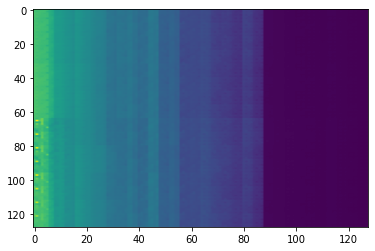

2020-11-23 08:51:06,866 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:0.025649, valid_AUC:0.472912, valid_pAUC:0.497802
100%|██████████| 855/855 [00:10<00:00, 82.48it/s]
2020-11-23 08:51:56,059 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:0.016524, valid_AUC:0.474945, valid_pAUC:0.493985
100%|██████████| 855/855 [00:10<00:00, 82.60it/s]
2020-11-23 08:52:45,311 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:0.015459, valid_AUC:0.472440, valid_pAUC:0.493667
100%|██████████| 855/855 [00:10<00:00, 82.36it/s]
2020-11-23 08:53:34,833 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:0.014786, valid_AUC:0.476154, valid_pAUC:0.495431
100%|██████████| 855/855 [00:10<00:00, 82.35it/s]
2020-11-23 08:54:24,158 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:0.014082, valid_AUC:0.472016, valid_pAUC:0.494130
100%|██████████| 855/855 [00:10<00:00, 82.40it/s]
2020-11-23 08:55:13,487 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:0.013835, valid_AUC:0.476852, valid_pA

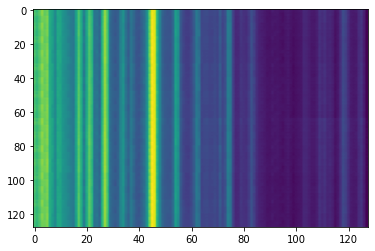

2020-11-23 08:58:31,139 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:0.013206, valid_AUC:0.477060, valid_pAUC:0.496270
100%|██████████| 855/855 [00:10<00:00, 82.29it/s]
2020-11-23 08:59:20,717 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:0.012999, valid_AUC:0.476478, valid_pAUC:0.496703
100%|██████████| 855/855 [00:10<00:00, 82.54it/s]
2020-11-23 09:00:10,019 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:0.012884, valid_AUC:0.477549, valid_pAUC:0.497166
100%|██████████| 855/855 [00:10<00:00, 82.74it/s]
2020-11-23 09:00:59,341 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:0.012765, valid_AUC:0.474758, valid_pAUC:0.496472
100%|██████████| 855/855 [00:10<00:00, 82.50it/s]
2020-11-23 09:01:48,687 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:0.012717, valid_AUC:0.475423, valid_pAUC:0.497687
100%|██████████| 855/855 [00:10<00:00, 82.71it/s]
2020-11-23 09:02:38,018 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:0.012623, valid_AUC:0.475687, va

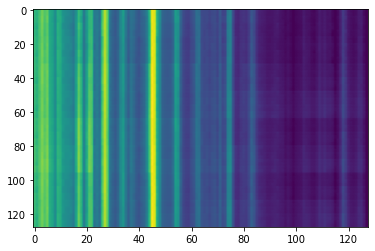

2020-11-23 09:06:45,212 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:0.012310, valid_AUC:0.476824, valid_pAUC:0.497773
100%|██████████| 855/855 [00:10<00:00, 82.78it/s]
2020-11-23 09:07:34,597 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:0.012224, valid_AUC:0.478736, valid_pAUC:0.497744
100%|██████████| 855/855 [00:10<00:00, 82.75it/s]
2020-11-23 09:08:23,951 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:0.012113, valid_AUC:0.479703, valid_pAUC:0.497889
100%|██████████| 855/855 [00:10<00:00, 82.59it/s]
2020-11-23 09:09:13,356 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:0.011840, valid_AUC:0.478538, valid_pAUC:0.497050
100%|██████████| 855/855 [00:10<00:00, 82.75it/s]
2020-11-23 09:10:02,674 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:0.011553, valid_AUC:0.487659, valid_pAUC:0.497224
100%|██████████| 855/855 [00:10<00:00, 82.65it/s]
2020-11-23 09:10:51,994 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:0.011107, valid_AUC:0.491516, va

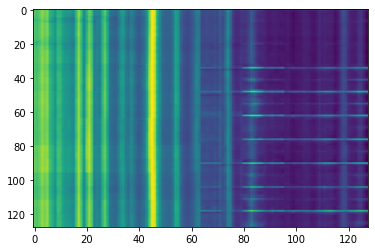

2020-11-23 09:14:58,811 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:0.010229, valid_AUC:0.493736, valid_pAUC:0.498352
100%|██████████| 855/855 [00:10<00:00, 82.75it/s]
2020-11-23 09:15:48,154 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:0.010174, valid_AUC:0.494209, valid_pAUC:0.498930
100%|██████████| 855/855 [00:10<00:00, 82.61it/s]
2020-11-23 09:16:37,470 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:0.010095, valid_AUC:0.497253, valid_pAUC:0.498178
100%|██████████| 855/855 [00:10<00:00, 82.87it/s]
2020-11-23 09:17:26,793 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:0.010014, valid_AUC:0.496005, valid_pAUC:0.498323
100%|██████████| 855/855 [00:10<00:00, 82.46it/s]
2020-11-23 09:18:16,164 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:0.009974, valid_AUC:0.502868, valid_pAUC:0.498352
100%|██████████| 855/855 [00:10<00:00, 80.77it/s]
2020-11-23 09:19:05,777 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:0.009940, valid_AUC:0.504099, va

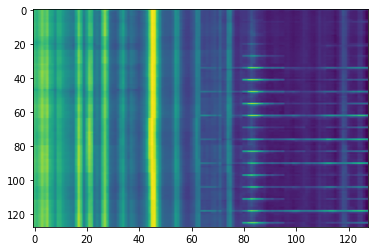

2020-11-23 09:23:12,905 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:0.009599, valid_AUC:0.510401, valid_pAUC:0.499364
100%|██████████| 855/855 [00:10<00:00, 81.99it/s]
2020-11-23 09:24:02,394 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:0.009525, valid_AUC:0.511978, valid_pAUC:0.499508
100%|██████████| 855/855 [00:10<00:00, 82.52it/s]
2020-11-23 09:24:51,750 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:0.009520, valid_AUC:0.506495, valid_pAUC:0.499971
100%|██████████| 855/855 [00:10<00:00, 82.55it/s]
2020-11-23 09:25:41,212 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:0.009469, valid_AUC:0.513714, valid_pAUC:0.499595
100%|██████████| 855/855 [00:10<00:00, 82.51it/s]
2020-11-23 09:26:30,537 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:0.009392, valid_AUC:0.513885, valid_pAUC:0.499971
100%|██████████| 855/855 [00:10<00:00, 82.52it/s]
2020-11-23 09:27:19,870 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:0.009352, valid_AUC:0.512500, va

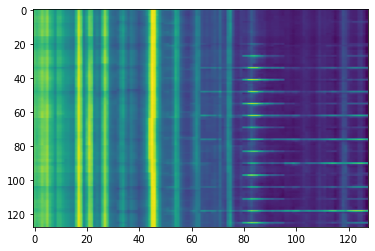

2020-11-23 09:31:26,802 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:0.009121, valid_AUC:0.522016, valid_pAUC:0.500087
100%|██████████| 855/855 [00:10<00:00, 82.67it/s]
2020-11-23 09:32:16,138 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:0.009071, valid_AUC:0.520835, valid_pAUC:0.500434
100%|██████████| 855/855 [00:10<00:00, 80.85it/s]
2020-11-23 09:33:05,675 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:0.009029, valid_AUC:0.522643, valid_pAUC:0.501012
100%|██████████| 855/855 [00:10<00:00, 82.76it/s]
2020-11-23 09:33:54,999 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:0.009016, valid_AUC:0.523654, valid_pAUC:0.500954
100%|██████████| 855/855 [00:10<00:00, 82.41it/s]
2020-11-23 09:34:44,298 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:0.008974, valid_AUC:0.532077, valid_pAUC:0.500781
100%|██████████| 855/855 [00:10<00:00, 82.64it/s]
2020-11-23 09:35:33,605 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:0.008923, valid_AUC:0.528662, va

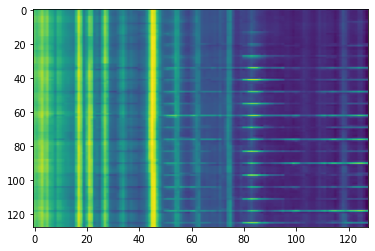

2020-11-23 09:39:40,239 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:0.008680, valid_AUC:0.529989, valid_pAUC:0.501446
100%|██████████| 855/855 [00:10<00:00, 82.60it/s]
2020-11-23 09:40:29,599 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:0.008630, valid_AUC:0.533544, valid_pAUC:0.501619
100%|██████████| 855/855 [00:10<00:00, 82.48it/s]
2020-11-23 09:41:19,018 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:0.008612, valid_AUC:0.536275, valid_pAUC:0.502111
100%|██████████| 855/855 [00:10<00:00, 82.33it/s]
2020-11-23 09:42:08,372 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:0.008534, valid_AUC:0.535390, valid_pAUC:0.502747
100%|██████████| 855/855 [00:10<00:00, 82.33it/s]
2020-11-23 09:42:57,759 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:0.008496, valid_AUC:0.535445, valid_pAUC:0.501938
100%|██████████| 855/855 [00:10<00:00, 82.58it/s]
2020-11-23 09:43:47,245 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:0.008491, valid_AUC:0.536758, va

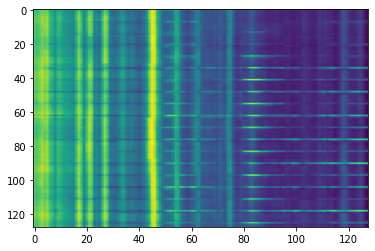

2020-11-23 09:47:54,573 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:0.008333, valid_AUC:0.533132, valid_pAUC:0.501648
100%|██████████| 855/855 [00:10<00:00, 82.38it/s]
2020-11-23 09:48:43,997 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:0.008313, valid_AUC:0.537868, valid_pAUC:0.501446
100%|██████████| 855/855 [00:10<00:00, 82.29it/s]
2020-11-23 09:49:33,624 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:0.008321, valid_AUC:0.534654, valid_pAUC:0.501330
100%|██████████| 855/855 [00:10<00:00, 82.77it/s]
2020-11-23 09:50:22,922 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:0.008236, valid_AUC:0.540571, valid_pAUC:0.501706
100%|██████████| 855/855 [00:10<00:00, 82.46it/s]
2020-11-23 09:51:12,283 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:0.008213, valid_AUC:0.535808, valid_pAUC:0.501880
100%|██████████| 855/855 [00:10<00:00, 82.72it/s]
2020-11-23 09:52:01,678 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:0.008178, valid_AUC:0.537923, va

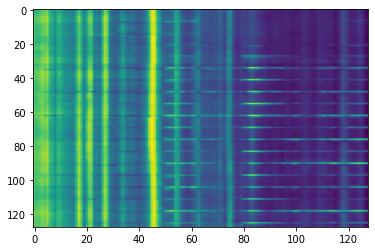

2020-11-23 09:56:08,662 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:0.008061, valid_AUC:0.541604, valid_pAUC:0.502516
100%|██████████| 855/855 [00:10<00:00, 82.46it/s]
2020-11-23 09:56:58,061 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:0.008026, valid_AUC:0.539555, valid_pAUC:0.502342
100%|██████████| 855/855 [00:10<00:00, 82.66it/s]
2020-11-23 09:57:47,425 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:0.008000, valid_AUC:0.540555, valid_pAUC:0.501822
100%|██████████| 855/855 [00:10<00:00, 82.78it/s]
2020-11-23 09:58:36,829 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:0.007991, valid_AUC:0.539291, valid_pAUC:0.501822
100%|██████████| 855/855 [00:10<00:00, 82.50it/s]
2020-11-23 09:59:26,321 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:0.007956, valid_AUC:0.541176, valid_pAUC:0.501938
100%|██████████| 855/855 [00:10<00:00, 82.66it/s]
2020-11-23 10:00:15,719 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:0.007946, valid_AUC:0.540016, va

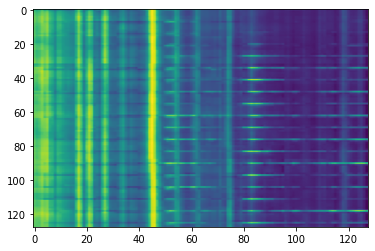

2020-11-23 10:04:23,156 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:0.007833, valid_AUC:0.537786, valid_pAUC:0.501388
100%|██████████| 855/855 [00:10<00:00, 82.07it/s]
2020-11-23 10:05:12,637 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:0.007801, valid_AUC:0.537885, valid_pAUC:0.501099
100%|██████████| 855/855 [00:10<00:00, 82.62it/s]
2020-11-23 10:06:01,987 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:0.007796, valid_AUC:0.535423, valid_pAUC:0.501070
100%|██████████| 855/855 [00:10<00:00, 82.37it/s]
2020-11-23 10:06:51,398 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:0.007766, valid_AUC:0.535923, valid_pAUC:0.501388
100%|██████████| 855/855 [00:10<00:00, 82.36it/s]
2020-11-23 10:07:40,904 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:0.007729, valid_AUC:0.539258, valid_pAUC:0.501909
100%|██████████| 855/855 [00:10<00:00, 82.48it/s]
2020-11-23 10:08:30,262 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:0.007697, valid_AUC:0.538401, va

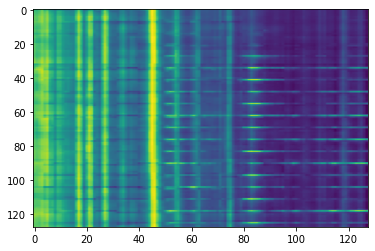

2020-11-23 10:12:37,339 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:0.007580, valid_AUC:0.539775, valid_pAUC:0.501562
2020-11-23 10:12:38,204 - 00_train.py - INFO - 
 success:valve 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/DAGMM_LSTM_CONV_vanilla/models/valve_model.pth


elapsed time: 5021.640391827 [sec]


In [11]:
for machine_type in machine_types:
    history = run(machine_type)
    with open('{}/{}_history.pkl'.format(PKL_DIR, machine_type), 'wb') as file:
        pickle.dump(history , file)

history = run('ToyCar')
with open('{}/{}_history.pkl'.format(PKL_DIR, machine_type), 'wb') as file:
    pickle.dump(history , file)